# File Preprocessing  

In [28]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt

In [29]:
cwd_path = Path.cwd()

In [30]:
og_train_path = os.path.join(cwd_path, "fruits-360/Training")
og_test_path  = os.path.join(cwd_path, "fruits-360/Test")

In [31]:
def getRandomFruitDirs(classCount):
    return np.random.choice(os.listdir(og_train_path), classCount, replace=False)

In [32]:
def MakeDirs(srcDir, newDirs):
    
    if type(newDirs) == str: 
        dirpath = os.path.join(srcDir, newDirs)
        if os.path.isdir(dirpath): 
            shutil.rmtree(dirpath)
        
        os.mkdir(dirpath)
    
    
    if type(newDirs) == list:    
        for dirname in newDirs:
            dirpath = os.path.join(srcDir, dirname)
            if os.path.isdir(dirpath):
                shutil.rmtree(dirpath)
        
            os.mkdir(dirpath)

In [33]:
def transferFile(srcPaths, destDir):
    if not os.path.isdir(destDir):     
        os.mkdir(destDir)
        
    for idx, imagePth in enumerate(srcPaths): 
        dPath = os.path.join(destDir, f"img{idx}.jpg")
        os.symlink(imagePth, dPath)
    

In [34]:
def getImageMatrix(links, title, image_size):

    sub_matrix = np.zeros(image_size[0] * image_size[1] * 3)
    labels = []
    for link in links: 
        vect_item = cv2.imread(link)
        vect_item = cv2.resize(vect_item, image_size)
        vect_item = cv2.cvtColor(vect_item, cv2.COLOR_BGR2RGB)
        sub_matrix = np.vstack((sub_matrix, vect_item.flatten()))
        labels.append(title)
        
    return sub_matrix[1:]/255, np.array(labels)

In [35]:
def getSamplesDir(sampleSize, valSize, testSize, selectedFruits, classDist = None): 
    trainSize = 1 - (valSize + testSize)
    train_fn = []
    test_fn = []
    val_fn = []

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")

        
    if testSize <= 0: 
        raise Exception("Training sample size too small!")

    train_sample_sz = int(trainSize * sampleSize)
    val_sample_sz = int(valSize * sampleSize) 
    test_sample_sz = int(testSize * sampleSize)

    subset_dir = "ML_FINAL_PROJECT/fruits-360"
    MakeDirs(subset_dir, "Subsets")
    
    subset_dir = "ML_FINAL_PROJECT/fruits-360/Subsets"
    
    subs = ["Train_sub", "Validation_sub", "Test_sub"]
    MakeDirs("ML_FINAL_PROJECT/fruits-360/Subsets", subs)

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        train_fn = np.random.choice(globbed_train, int(train_sample_sz * cDist[idx]), replace = False)
        testval_fn = np.random.choice(globbed_test, int((test_sample_sz  + val_sample_sz)*cDist[idx]), replace = False)

        test_fn, val_fn = testval_fn[ : int(test_sample_sz * cDist[idx])],  testval_fn[int(test_sample_sz * cDist[idx]) + 1 :]
        
        transferFile(train_fn, os.path.join(subset_dir, subs[0], fruit))
        transferFile(val_fn, os.path.join(subset_dir, subs[1], fruit))
        transferFile(test_fn, os.path.join(subset_dir, subs[2], fruit)) 

In [36]:
def getSamplesMat(sampleSize, selectedFruits, classDist = None, resize = (100, 100)): 
    matrix = np.zeros(shape = (1, resize[0] * resize[1] * 3))
    labels = np.zeros(0)

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")
        return 
        

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        fn = np.random.choice(globbed_train + globbed_test, int(sampleSize * cDist[idx]) ,replace = False)
        res_matrix, new_labels = getImageMatrix(fn, fruit,resize)        
        
        matrix = np.vstack([matrix, res_matrix])
        labels = np.concatenate([labels, new_labels])
        
    return matrix[1:], labels, fn[0]

In [37]:
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv

# Logistic Regression
## Testing similar color but different shapes

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

sample_size = 300
trainClassDist = [0.95, 0.05]
trainClassDistThree = [0.80, 0.10, 0.10]
classDist = None
resizes = (20,20)

                   precision    recall  f1-score   support

   Apple Braeburn       1.00      1.00      1.00         1
  Apple Pink Lady       0.67      0.40      0.50         5
          Apricot       1.00      1.00      1.00         4
         Cherry 2       0.50      1.00      0.67         2
    Cucumber Ripe       1.00      1.00      1.00         3
       Grape Pink       1.00      1.00      1.00         3
             Kaki       1.00      1.00      1.00         1
        Mango Red       0.71      1.00      0.83         5
            Peach       1.00      0.75      0.86         4
     Pear Forelle       1.00      0.50      0.67         4
         Pear Red       1.00      1.00      1.00         3
       Pepper Red       0.50      0.50      0.50         2
      Pomegranate       1.00      1.00      1.00         1
       Strawberry       1.00      1.00      1.00         2
        Tamarillo       1.00      0.33      0.50         3
         Tomato 1       1.00      1.00      1.00       

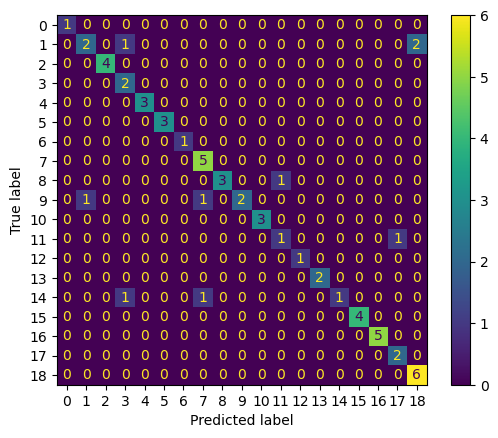

In [39]:
#Testing red fruits
fruits = [
    "Grape Pink", "Tomato Cherry Red", "Tomato Maroon", "Apple Pink Lady", "Apricot",
    "Tomato 1", "Peach", "Cherry 2", "Apple Braeburn", "Tomato Heart",
    "Pepper Red", "Pomegranate", "Mango Red", "Pear Red", "Kaki", "Onion Red",
    "Strawberry", "Tamarillo", "Cucumber Ripe", "Pear Forelle"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                   precision    recall  f1-score   support

   Apple Braeburn       0.38      1.00      0.55         3
  Apple Pink Lady       0.75      0.75      0.75         4
          Apricot       1.00      1.00      1.00         1
         Cherry 2       1.00      0.50      0.67         2
    Cucumber Ripe       0.67      1.00      0.80         2
       Grape Pink       1.00      1.00      1.00         3
             Kaki       1.00      1.00      1.00         4
        Mango Red       1.00      1.00      1.00         1
        Onion Red       0.83      0.71      0.77         7
            Peach       0.50      0.40      0.44         5
     Pear Forelle       0.75      0.60      0.67         5
         Pear Red       1.00      1.00      1.00         1
       Pepper Red       1.00      1.00      1.00         2
      Pomegranate       1.00      0.33      0.50         6
       Strawberry       1.00      0.67      0.80         3
        Tamarillo       0.67      1.00      0.80       

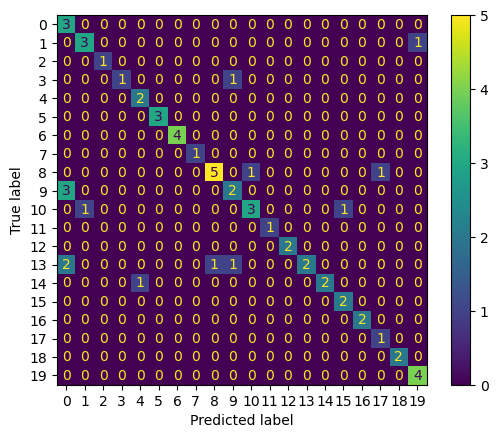

In [40]:
#Testing red fruits (greyscaled)
fruits = [
    "Grape Pink", "Tomato Cherry Red", "Tomato Maroon", "Apple Pink Lady", "Apricot",
    "Tomato 1", "Peach", "Cherry 2", "Apple Braeburn", "Tomato Heart",
    "Pepper Red", "Pomegranate", "Mango Red", "Pear Red", "Kaki", "Onion Red",
    "Strawberry", "Tamarillo", "Cucumber Ripe", "Pear Forelle"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                    precision    recall  f1-score   support

Apple Red Yellow 1       1.00      1.00      1.00         5
           Apricot       1.00      1.00      1.00         3
         Carambula       1.00      1.00      1.00         4
 Cherry Wax Yellow       1.00      1.00      1.00         4
   Grapefruit Pink       1.00      1.00      1.00         2
  Grapefruit White       1.00      1.00      1.00         4
              Kaki       1.00      1.00      1.00         2
             Lemon       1.00      1.00      1.00         2
         Mandarine       1.00      1.00      1.00         1
          Maracuja       1.00      1.00      1.00         3
             Peach       1.00      1.00      1.00         6
           Peach 2       0.75      1.00      0.86         3
          Pear Red       1.00      0.67      0.80         3
     Pepper Orange       0.67      1.00      0.80         2
     Pepper Yellow       1.00      0.67      0.80         3
    Pomelo Sweetie       1.00      1.00

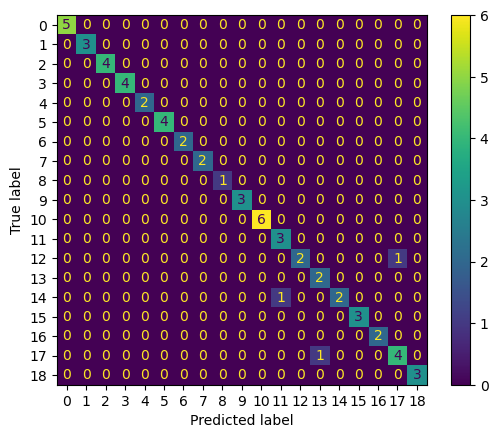

In [41]:
#Testing yellow/orange fruits
fruits = [
    "Pepper Yellow", "Grapefruit Pink", "Tomato Yellow", "Mandarine", "Tangelo",
    "Grapefruit White", "Cherry Wax Yellow", "Kaki", "Peach 2", "Apple Red Yellow 1",
    "Lemon", "Pomelo Sweetie", "Pear Red", "Pepper Orange", "Peach", "Maracuja", 
    "Apricot", "Cucumber Ripe 2", "Carambula", "Tomato 2"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                    precision    recall  f1-score   support

Apple Red Yellow 1       1.00      0.60      0.75         5
           Apricot       0.43      1.00      0.60         3
         Carambula       1.00      0.67      0.80         3
 Cherry Wax Yellow       0.83      1.00      0.91         5
   Cucumber Ripe 2       1.00      0.50      0.67         2
   Grapefruit Pink       0.80      1.00      0.89         4
  Grapefruit White       0.75      1.00      0.86         3
              Kaki       1.00      1.00      1.00         3
             Lemon       1.00      0.25      0.40         4
         Mandarine       0.50      0.67      0.57         3
          Maracuja       0.00      0.00      0.00         1
             Peach       0.33      0.50      0.40         2
           Peach 2       1.00      1.00      1.00         3
          Pear Red       0.67      0.67      0.67         3
     Pepper Orange       1.00      0.67      0.80         3
     Pepper Yellow       0.40      1.00

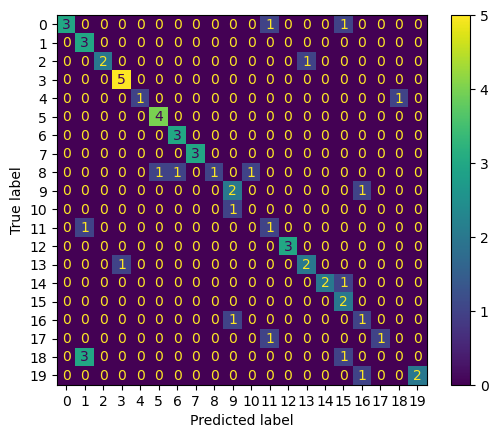

In [42]:
#Testing yellow/orange fruits (greyscaled)
fruits = [
    "Pepper Yellow", "Grapefruit Pink", "Tomato Yellow", "Mandarine", "Tangelo",
    "Grapefruit White", "Cherry Wax Yellow", "Kaki", "Peach 2", "Apple Red Yellow 1",
    "Lemon", "Pomelo Sweetie", "Pear Red", "Pepper Orange", "Peach", "Maracuja", 
    "Apricot", "Cucumber Ripe 2", "Carambula", "Tomato 2"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                    precision    recall  f1-score   support

    Apple Golden 3       0.67      0.80      0.73         5
Apple Granny Smith       1.00      0.50      0.67         4
           Avocado       1.00      1.00      1.00         2
         Blueberry       1.00      1.00      1.00         3
          Cherry 1       0.75      1.00      0.86         3
  Cherry Wax Black       1.00      1.00      1.00         6
        Grape Blue       1.00      1.00      1.00         3
     Grape White 3       1.00      1.00      1.00         4
     Grape White 4       1.00      1.00      1.00         2
             Guava       1.00      1.00      1.00         2
             Limes       0.67      0.67      0.67         3
             Mango       0.50      1.00      0.67         2
        Nut Forest       0.67      1.00      0.80         4
      Pepper Green       1.00      1.00      1.00         2
         Pineapple       1.00      1.00      1.00         2
              Plum       1.00      0.75

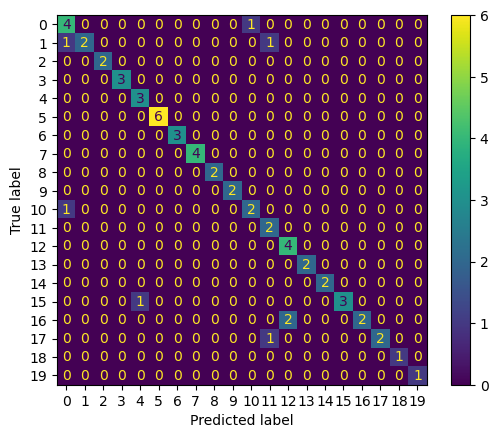

In [43]:
#Testing Green Fruits
fruits = ['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Avocado', 'Grape White 3',
         'Cherry Wax Black', 'Blueberry', 'Cherry 1', 'Plum 3', 'Plum',
         'Nut Forest', 'Mango', 'Pomelo Sweetie', 'Limes', 'Pineapple',
         'Apple Granny Smith', 'Guava', 'Watermelon', 'Apple Golden 3']
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                    precision    recall  f1-score   support

    Apple Golden 3       0.67      0.67      0.67         3
Apple Granny Smith       1.00      0.75      0.86         4
           Avocado       1.00      0.83      0.91         6
         Blueberry       1.00      0.67      0.80         3
          Cherry 1       1.00      0.67      0.80         3
  Cherry Wax Black       1.00      1.00      1.00         2
        Grape Blue       0.67      1.00      0.80         4
     Grape White 3       1.00      1.00      1.00         4
     Grape White 4       0.75      1.00      0.86         3
             Guava       0.67      0.67      0.67         3
             Limes       1.00      1.00      1.00         2
             Mango       0.75      1.00      0.86         3
        Nut Forest       1.00      0.33      0.50         3
      Pepper Green       1.00      1.00      1.00         1
         Pineapple       1.00      1.00      1.00         1
              Plum       0.71      1.00

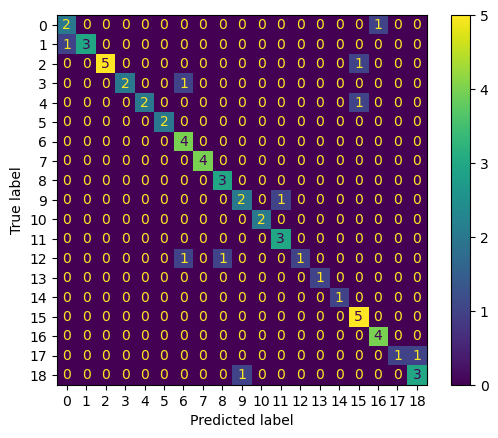

In [44]:
#Testing Green Fruits (greyscaled)
fruits = ['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Avocado', 'Grape White 3',
         'Cherry Wax Black', 'Blueberry', 'Cherry 1', 'Plum 3', 'Plum',
         'Nut Forest', 'Mango', 'Pomelo Sweetie', 'Limes', 'Pineapple',
         'Apple Granny Smith', 'Guava', 'Watermelon', 'Apple Golden 3']
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

## Testing similar shape but different colors

                   precision    recall  f1-score   support

          Apricot       0.60      0.75      0.67         4
     Cantaloupe 1       1.00      1.00      1.00         5
     Cantaloupe 2       1.00      1.00      1.00         2
         Cherry 1       0.75      1.00      0.86         3
         Cherry 2       1.00      1.00      1.00         3
 Cherry Wax Black       1.00      1.00      1.00         1
   Cherry Wax Red       1.00      1.00      1.00         2
Cherry Wax Yellow       1.00      1.00      1.00         2
       Clementine       1.00      1.00      1.00         3
       Grape Blue       1.00      1.00      1.00         4
      Grape White       1.00      1.00      1.00         4
  Grapefruit Pink       1.00      1.00      1.00         4
        Nectarine       1.00      0.33      0.50         3
           Orange       0.50      1.00      0.67         1
            Peach       1.00      0.50      0.67         2
             Plum       0.67      0.67      0.67       

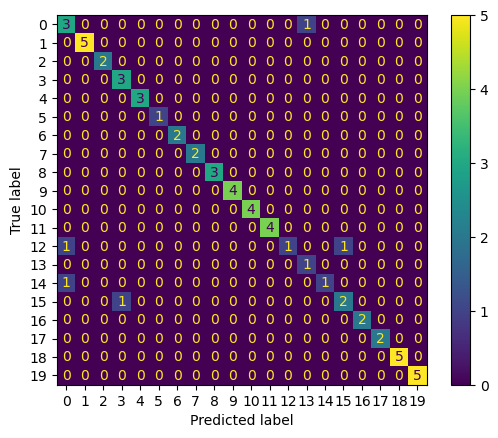

In [45]:
#Testing circular fruits
fruits = [
    "Cantaloupe 1", "Cantaloupe 2", "Cherry 1", "Cherry 2", "Apricot",
    "Cherry Wax Black", "Cherry Wax Red", "Cherry Wax Yellow", "Clementine",
    "Grape Blue", "Grape White", "Grapefruit Pink", "Nectarine", "Orange",
    "Peach", "Plum", "Plum 2", "Tomato Cherry Red", "Walnut", "Watermelon"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                     precision    recall  f1-score   support

     Apple Braeburn       1.00      0.75      0.86         4
 Apple Crimson Snow       0.71      1.00      0.83         5
     Apple Golden 1       1.00      0.67      0.80         3
 Apple Granny Smith       1.00      0.83      0.91         6
    Apple Pink Lady       1.00      0.40      0.57         5
        Apple Red 1       0.67      1.00      0.80         2
Apple Red Delicious       1.00      1.00      1.00         1
 Apple Red Yellow 1       1.00      1.00      1.00         3
           Beetroot       0.50      1.00      0.67         1
          Blueberry       1.00      1.00      1.00         2
                Fig       1.00      0.33      0.50         3
              Guava       1.00      1.00      1.00         1
               Kiwi       0.80      1.00      0.89         4
              Lemon       0.75      1.00      0.86         3
        Lemon Meyer       1.00      1.00      1.00         7
              Limes    

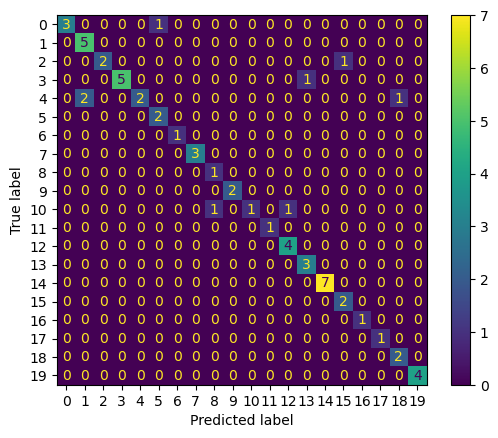

In [46]:
#Testing not quite circular fruits
fruits = [
    "Apple Braeburn", "Apple Crimson Snow", "Apple Golden 1", "Apple Granny Smith",
    "Apple Pink Lady", "Apple Red 1", "Apple Red Delicious", "Apple Red Yellow 1",
    "Beetroot", "Blueberry", "Fig", "Guava", "Lemon", "Limes", "Onion Red",
    "Onion White", "Pepper Red", "Lemon Meyer", "Mango Red", "Kiwi"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

                    precision    recall  f1-score   support

           Avocado       1.00      1.00      1.00         1
      Avocado Ripe       1.00      1.00      1.00         3
            Banana       0.75      1.00      0.86         3
Banana Lady Finger       0.75      0.50      0.60         6
        Banana Red       1.00      0.71      0.83         7
      Cactus fruit       1.00      1.00      1.00         1
         Carambula       1.00      1.00      1.00         1
              Corn       1.00      0.67      0.80         3
         Corn Husk       0.75      1.00      0.86         3
     Cucumber Ripe       0.75      1.00      0.86         3
          Eggplant       1.00      1.00      1.00         4
          Hazelnut       1.00      1.00      1.00         5
          Kumquats       1.00      1.00      1.00         3
Melon Piel de Sapo       1.00      1.00      1.00         2
         Nut Pecan       1.00      1.00      1.00         3
        Pear Abate       0.67      1.00

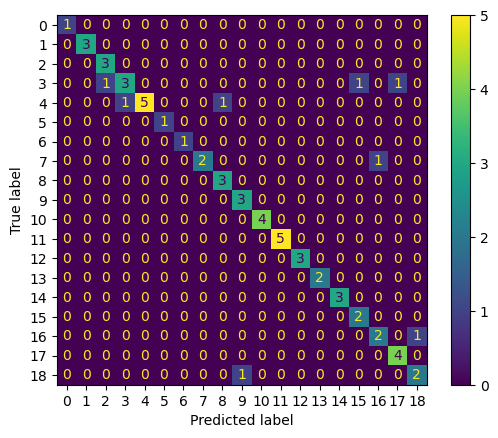

In [47]:
#Testing tubular fruits
fruits = [
    "Eggplant", "Avocado", "Avocado Ripe", "Banana", "Banana Lady Finger", "Banana Red",
    "Cactus fruit", "Carambula", "Corn", "Cucumber Ripe", "Hazelnut", "Kumquats",
    "Pear 2", "Pear Red", "Pepino", "Tomato 2", "Nut Pecan", "Melon Piel de Sapo",
    "Pear Abate", "Corn Husk"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

## Random Fruits

In [48]:
count = 40
sample_size = 500

C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

    Apple Braeburn       1.00      1.00      1.00         4
    Apple Golden 2       1.00      1.00      1.00         2
       Apple Red 2       0.60      1.00      0.75         3
       Apple Red 3       1.00      0.50      0.67         4
Apple Red Yellow 2       1.00      1.00      1.00         1
           Apricot       1.00      0.75      0.86         4
            Banana       0.33      1.00      0.50         1
        Banana Red       0.67      0.50      0.57         4
 Cherry Wax Yellow       1.00      1.00      1.00         2
             Cocos       0.50      1.00      0.67         2
              Corn       1.00      0.50      0.67         2
     Cucumber Ripe       0.00      0.00      0.00         2
   Cucumber Ripe 2       1.00      1.00      1.00         5
        Grape Pink       1.00      1.00      1.00         1
     Grape White 4       1.00      1.00      1.00         3
             Guava       1.00      1.00

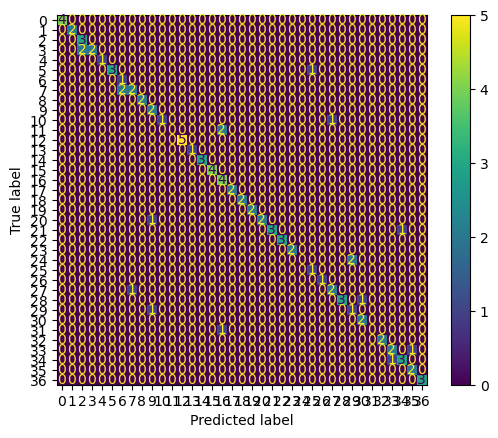

In [49]:
#Random Fruits 1
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

    Apple Braeburn       0.75      0.75      0.75         4
Apple Crimson Snow       0.60      1.00      0.75         3
       Apple Red 1       1.00      1.00      1.00         2
Apple Red Yellow 2       1.00      1.00      1.00         2
      Cantaloupe 1       1.00      1.00      1.00         2
         Carambula       1.00      1.00      1.00         2
          Cherry 1       0.75      1.00      0.86         3
          Cherry 2       0.00      0.00      0.00         3
    Cherry Rainier       0.25      1.00      0.40         1
         Corn Husk       1.00      1.00      1.00         2
       Ginger Root       1.00      1.00      1.00         2
        Granadilla       0.50      0.50      0.50         2
        Grape Blue       0.75      1.00      0.86         3
          Kohlrabi       0.33      1.00      0.50         1
          Kumquats       1.00      1.00      1.00         4
             Lemon       1.00      1.00

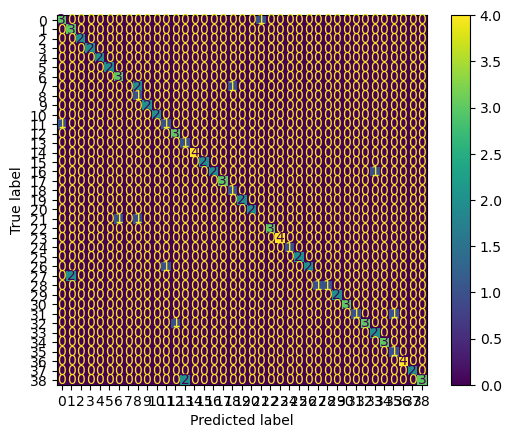

In [50]:
#Random Fruits 2
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

In [ ]:
#Random Fruits 3
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

lr_classifier = LogisticRegression(random_state=42, max_iter = 2000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=5)
#print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chlaw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

    Apple Golden 2       0.67      1.00      0.80         2
       Apple Red 1       1.00      1.00      1.00         1
       Apple Red 3       0.50      1.00      0.67         1
Apple Red Yellow 1       1.00      0.33      0.50         3
Apple Red Yellow 2       0.67      1.00      0.80         2
      Avocado ripe       1.00      1.00      1.00         3
    Cherry Rainier       1.00      0.80      0.89         5
        Clementine       1.00      1.00      1.00         2
             Cocos       0.67      1.00      0.80         2
              Corn       1.00      0.50      0.67         2
   Cucumber Ripe 2       1.00      1.00      1.00         2
             Dates       1.00      0.67      0.80         3
          Eggplant       1.00      1.00      1.00         1
        Granadilla       1.00      0.50      0.67         4
  Grapefruit White       0.67      1.00      0.80         2
             Guava       1.00      1.00